In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import gc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load the Preprocessed Data

In [ ]:
data = pd.read_csv('New_clean_dataset.csv') # New_clean_dataset.csv, imputed_data.csv, train.csv

# RNN and Transformer Hybrid Model Using Numerical Features Only


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, max_loss_gap=None):
        """
        Initialize the EarlyStopping mechanism.
        :param patience: Number of epochs to wait after the last improvement.
        :param min_delta: Minimum change in the monitored metric to qualify as an improvement.
        :param max_loss_gap: Maximum allowed gap between train and validation loss.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.max_loss_gap = max_loss_gap
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss, train_loss):
        """
        Check if early stopping criteria are met.
        :param val_loss: Current validation loss.
        :param train_loss: Current training loss.
        """
        # Check if validation loss has improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is observed
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

        # Check if the gap between train and validation loss exceeds max_loss_gap
        if self.max_loss_gap is not None:
            if abs(train_loss - val_loss) > self.max_loss_gap:
                print(f"Stopping early due to excessive loss gap: Train Loss = {train_loss}, Val Loss = {val_loss}")
                self.stop = True

In [ ]:
class RNNTransformerNoCategorical(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 num_layers, 
                 output_dim, 
                 num_heads, 
                 ff_dim, 
                 dropout_rate=0.1, 
                 max_seq_len=12, 
                 use_learnable_positional_encoding=True, 
                 activation="relu"):
        super(RNNTransformerNoCategorical, self).__init__()

        # RNN (GRU)
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)

        # Layer Normalization for RNN outputs
        self.rnn_norm = nn.LayerNorm(hidden_dim)

        # Positional Encoding
        self.use_learnable_positional_encoding = use_learnable_positional_encoding
        d_model = hidden_dim  # No categorical embeddings
        self.d_model = d_model
        if use_learnable_positional_encoding:
            self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))  # Learnable
        else:
            self.positional_encoding = self.sinusoidal_positional_encoding(max_seq_len, d_model)  # Precomputed

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout_rate,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(d_model, output_dim)

    def sinusoidal_positional_encoding(self, max_len, d_model):
        """Compute sinusoidal positional encoding."""
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        return pe

    def forward(self, numerical, src_key_padding_mask=None):
        # Pass numerical features through RNN
        rnn_out, _ = self.rnn(numerical)  # Shape: [batch_size, seq_length, hidden_dim]
        rnn_out = self.rnn_norm(rnn_out)  # Normalize RNN outputs

        # Add positional encoding
        if self.use_learnable_positional_encoding:
            x = rnn_out + self.positional_encoding[:, :rnn_out.size(1), :]
        else:
            x = rnn_out + self.positional_encoding[:, :rnn_out.size(1), :].to(rnn_out.device)

        # Pass through Transformer Encoder
        transformer_out = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)

        # Take the last time step and predict
        output = self.fc(transformer_out[:, -1, :])
        return output

In [ ]:
# Handle categorical `activity-x:xx` variables
activity_columns = [col for col in data.columns if col.startswith('activity-')]
for col in activity_columns:
    data[col] = data[col].astype('category').cat.codes  # Convert strings to integer codes

# Map category counts for embedding
activity_vocab_size = data[activity_columns].max().max() + 1  # Total unique categories

# Drop hr and carbs columns
additional_columns_to_drop = [col for col in data.columns if col.startswith(('hr','carbs'))] # ,'insulin','steps'

# Extract features and target
numerical_features = data.drop(columns=['id', 'p_num', 'time', 'bg+1:00', *activity_columns, *additional_columns_to_drop]).values
categorical_features = data[activity_columns].values
target = data['bg+1:00'].values

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(numerical_features)

# Reshape features for time-series input
sequence_length = 12  # Number of timesteps - past ~3 hours
numerical_features = torch.tensor(numerical_features, dtype=torch.float32).view(
    -1, sequence_length, numerical_features.shape[1] // sequence_length)
categorical_features = torch.tensor(categorical_features, dtype=torch.long).view(
    -1, sequence_length, len(activity_columns) // sequence_length)
target = torch.tensor(target, dtype=torch.float32)

# Train-test split
numerical_features_train, numerical_features_test, \
categorical_features_train, categorical_features_test, \
target_train, target_test = train_test_split(
    numerical_features, categorical_features, target, test_size=0.2, random_state=42)

# Handle nan and infinite values
numerical_features_train = torch.nan_to_num(numerical_features_train, nan=0.0, posinf=1e5, neginf=-1e5)
numerical_features_test = torch.nan_to_num(numerical_features_test, nan=0.0, posinf=1e5, neginf=-1e5)

# Further split train data into train/validation (80/20 split) -- HW 3
numerical_features_train_split, numerical_features_val, \
categorical_features_train_split, categorical_features_val, \
target_train_split, target_val = train_test_split(
    numerical_features_train, categorical_features_train, target_train, test_size=0.2, random_state=42)


## Fitting the Model

Epoch 1/160, Train Loss: 8.1777, Validation Loss: 5.3161
Best model saved at epoch 1 with validation loss 5.3161
Learning rate: 0.002
Epoch 2/160, Train Loss: 5.2919, Validation Loss: 5.0955
Best model saved at epoch 2 with validation loss 5.0955
Learning rate: 0.002
Epoch 3/160, Train Loss: 5.1921, Validation Loss: 4.8498
Best model saved at epoch 3 with validation loss 4.8498
Learning rate: 0.002
Epoch 4/160, Train Loss: 4.9459, Validation Loss: 5.1335
Learning rate: 0.002
Epoch 5/160, Train Loss: 4.8734, Validation Loss: 4.9173
Learning rate: 0.002
Epoch 6/160, Train Loss: 4.8415, Validation Loss: 5.1028
Learning rate: 0.002
Epoch 7/160, Train Loss: 4.7286, Validation Loss: 4.9593
Learning rate: 0.002
Epoch 8/160, Train Loss: 4.7036, Validation Loss: 4.9475
Learning rate: 0.002
Epoch 9/160, Train Loss: 4.6459, Validation Loss: 5.1215
Learning rate: 0.002
Epoch 10/160, Train Loss: 4.6171, Validation Loss: 4.9186
Learning rate: 0.002
Epoch 11/160, Train Loss: 4.6521, Validation Loss: 

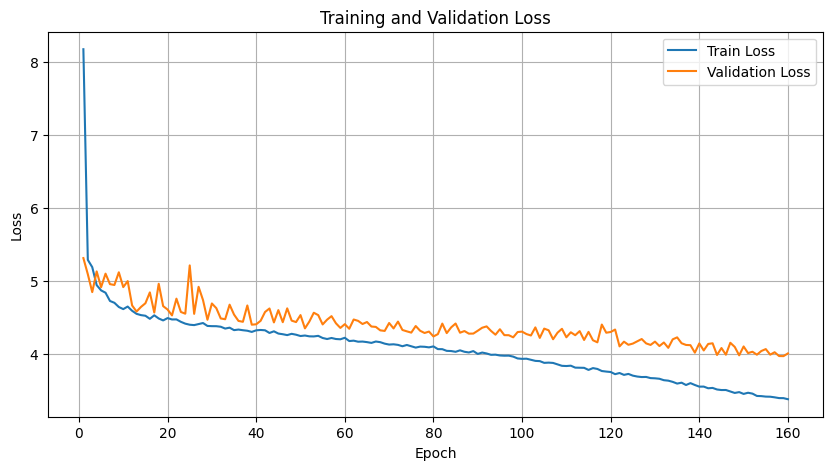

In [ ]:
input_dim = numerical_features_train.size(-1)
hidden_dim = 64 #64
num_layers = 2
output_dim = 1
num_heads = 4
max_seq_len= 12  # Maximum sequence length for positional encoding
use_learnable_positional_encoding=True  # Option for learnable positional encoding
activation="relu"
embedding_dim = 8
dropout_rate = 0.1
ff_dim = 128

model = RNNTransformerNoCategorical(
    input_dim=input_dim, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers, 
    output_dim=output_dim, 
    num_heads=num_heads, 
    ff_dim=ff_dim, 
    dropout_rate=dropout_rate, 
    max_seq_len=max_seq_len, 
    use_learnable_positional_encoding=use_learnable_positional_encoding, 
    activation=activation
)

# Initialize early stopping parameters
early_stop_patience = 2
val_loss_threshold = 4.0  # Early stopping begins when validation loss is ≤ 4.0
loss_gap_threshold = 0.6
early_stop_counter = 0

best_val_loss = float('inf')  # Track the best validation loss
train_losses = []
test_losses = []

batch_size = 126
lr = .002
num_epochs = 160

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4) # Use adam optimizer with L2 penalized weight decay
criterion = nn.MSELoss() # MSE metric loss

# Learning rate scheduler: Reduce learning rate when validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    for i in range(0, numerical_features_train_split.size(0), batch_size):
        # Get batch data for training
        x_train_numerical = numerical_features_train_split[i:i + batch_size]
        y_train = target_train_split[i:i + batch_size]

        # forward pass
        optimizer.zero_grad()
        outputs = model(x_train_numerical)

        # compute loss
        loss = criterion(outputs.squeeze(), y_train)
        
        # backward pass
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # update parameters
        optimizer.step()
        
        # accumulate training loss
        epoch_train_loss += loss.item()

    # calculate average training loss
    avg_train_loss = epoch_train_loss / (numerical_features_train_split.size(0) / batch_size)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, numerical_features_val.size(0), batch_size):
            # Get batch data for validation
            x_val_numerical = numerical_features_val[i:i + batch_size]
            y_val = target_val[i:i + batch_size]

            # forward pass
            val_outputs = model(x_val_numerical)
            
            # compute loss
            val_loss += criterion(val_outputs.squeeze(), y_val).item()

        # calculate average validation loss
        avg_val_loss = val_loss / (numerical_features_val.size(0) / batch_size)
        test_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved at epoch {epoch + 1} with validation loss {best_val_loss:.4f}")
        early_stop_counter = 0  # Reset counter if validation improves
    else:
        # Check early stopping conditions only if validation loss ≤ threshold
        if avg_val_loss <= val_loss_threshold and (avg_val_loss - avg_train_loss) > loss_gap_threshold:
            early_stop_counter += 1
            print(f"Early stopping condition met for {early_stop_counter} consecutive epochs.")
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break
        else:
            early_stop_counter = 0  # Reset counter if conditions are not met

    # Adjust learning rate with the scheduler
    scheduler.step(val_loss)
    for param_group in optimizer.param_groups:
        print(f"Learning rate: {param_group['lr']}")

# Test phase
model.eval()
test_loss = 0
with torch.no_grad():
    for i in range(0, numerical_features_test.size(0), batch_size):
        # Get batch data for testing
        x_test_numerical = numerical_features_test[i:i + batch_size]
        y_test = target_test[i:i + batch_size]

        # forward pass
        test_outputs = model(x_test_numerical)

        # compute loss
        test_loss += criterion(test_outputs.squeeze(), y_test).item()

    # calculate average test loss
    avg_test_loss = test_loss / (numerical_features_test.size(0) / batch_size)
    print(f"Test Loss: {avg_test_loss:.4f}")

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


## Generating Predictions and Evaluating the Test Set

In [ ]:
time_start = 23964
time_end = time_start+126

In [ ]:
numerical_features_test = data[time_start:time_end]

numerical_features = data[time_start:time_end].drop(columns=['id', 'p_num', 'time', 'bg+1:00', *activity_columns, *additional_columns_to_drop]).values
numerical_features = scaler.fit_transform(numerical_features)
sequence_length = 12  # Number of timesteps
numerical_features_test = torch.tensor(numerical_features, dtype=torch.float32).view(
    -1, sequence_length, numerical_features.shape[1] // sequence_length)
numerical_features_test = torch.nan_to_num(numerical_features_test, nan=0.0, posinf=1e5, neginf=-1e5)


In [ ]:
# Test phase with predictions stored
model.eval()
test_loss = 0
all_predictions = []  # To store predictions
all_actuals = []      # To store actual values

with torch.no_grad():
    for i in range(0, numerical_features_test.size(0), batch_size):
        # Get batch data for testing
        x_test_numerical = numerical_features_test[i:i + batch_size]
        y_test = target_test[i:i + batch_size]

        # Forward pass
        test_outputs = model(x_test_numerical)

        # Compute loss
        test_loss += criterion(test_outputs.squeeze(), y_test).item()

        # Store predictions and actuals
        all_predictions.extend(test_outputs.squeeze().tolist())
        all_actuals.extend(y_test.tolist())

# Calculate average test loss
avg_test_loss = test_loss / (numerical_features_test.size(0) / batch_size)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 61.2306


In [ ]:
ab = data[time_start:time_end]
ab['predicted bg+1:00'] = all_predictions


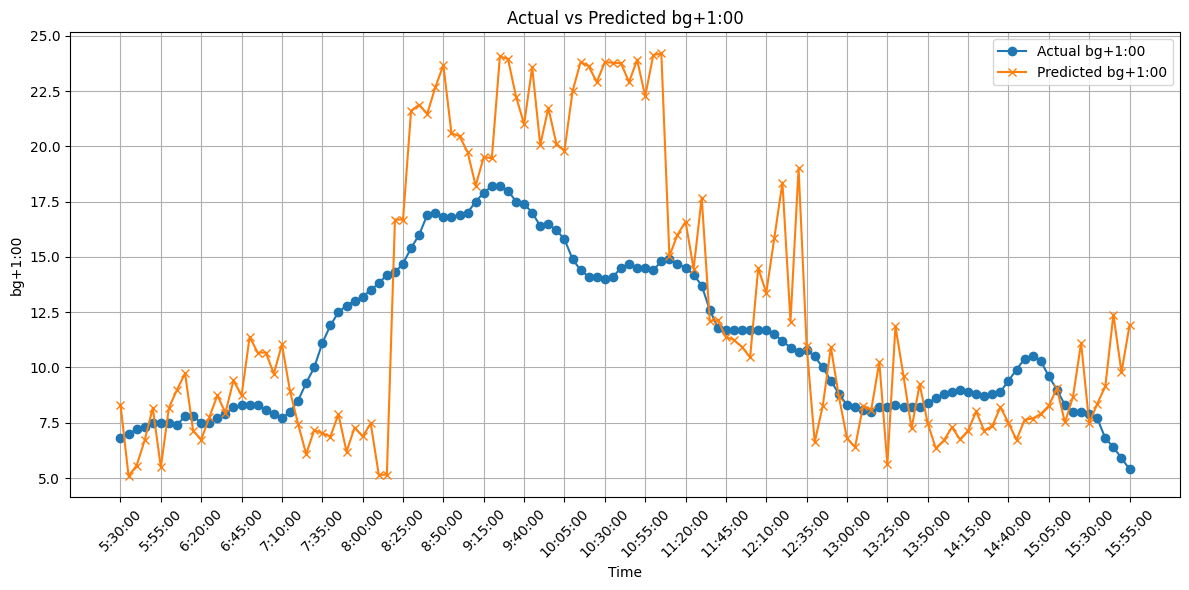

In [ ]:
ab[['id','time','p_num','bg+1:00','predicted bg+1:00']]

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(ab['time'], ab['bg+1:00'], label='Actual bg+1:00', marker='o')
plt.plot(ab['time'], ab['predicted bg+1:00'], label='Predicted bg+1:00', marker='x')

# Add labels, title, legend, and grid
plt.xlabel('Time')
plt.ylabel('bg+1:00')
plt.title('Actual vs Predicted bg+1:00')
plt.legend()
# Adjust x-ticks to skip every 5th tick
plt.xticks(ticks=ab['time'][::5], labels=ab['time'][::5], rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
len(all_predictions)

126

In [ ]:
# Extract features and target
numerical_features = data.drop(columns=[*activity_columns, *additional_columns_to_drop]) #'id', 'p_num', 'time', 'bg+1:00', 
categorical_features = data[activity_columns]
target = data['bg+1:00']

# # Train-test split
numerical_features_train_df, numerical_features_test_df, \
categorical_features_train_df, categorical_features_test_df, \
target_train_df, target_test_df = train_test_split(
    numerical_features, categorical_features, target, test_size=0.2, random_state=42)

In [ ]:
numerical_features_test_df['predicted bg+1:00'] = all_predictions

In [ ]:
numerical_features_test_df[['id','p_num','time','bg+1:00','predicted bg+1:00']]

,id,p_num,time,bg+1:00,predicted bg+1:00
49463,p06_8023,p06,1:05:00,5.3,5.977325
24898,p04_34,p04,8:55:00,6.2,6.242822
37762,p05_4610,p05,6:35:00,3.6,4.722198
16435,p02_8147,p02,23:50:00,8.2,10.391666
66030,p11_8014,p11,1:25:00,11.7,11.270608
...,...,...,...,...,...
6,p01_6,p01,7:40:00,11.9,16.406708
54039,p10_4311,p10,9:15:00,7.4,6.528949
74408,p12_8104,p12,8:20:00,7.2,6.694233
37000,p05_3848,p05,1:00:00,9.6,11.494823


In [ ]:
# Calculate residuals
numerical_features_test_df['residual'] = numerical_features_test_df['bg+1:00'] - numerical_features_test_df['predicted bg+1:00']

# Calculate average residuals grouped by p_num
avg_residuals = numerical_features_test_df.groupby('p_num')['residual'].mean().reset_index()
avg_residuals.rename(columns={'residual': 'average_residual'}, inplace=True)

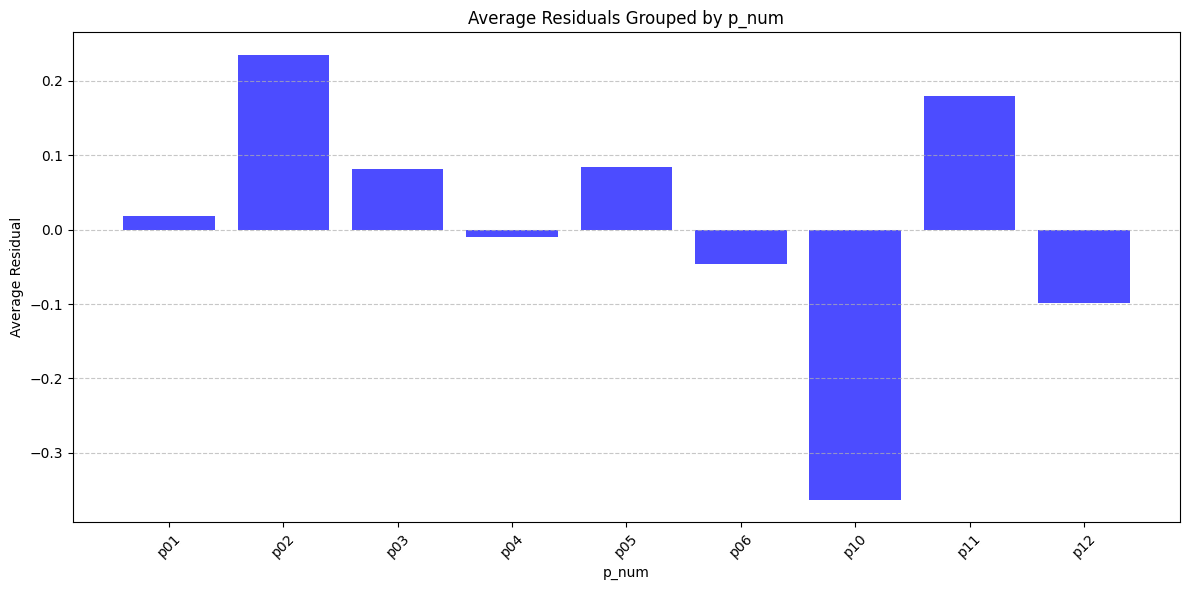

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(avg_residuals['p_num'], avg_residuals['average_residual'], color='blue', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('p_num')
plt.ylabel('Average Residual')
plt.title('Average Residuals Grouped by p_num')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# RNN and Transformer Hybrid Model Using Numerical and Categorical Features

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, max_loss_gap=None):
        """
        Initialize the EarlyStopping mechanism.
        :param patience: Number of epochs to wait after the last improvement.
        :param min_delta: Minimum change in the monitored metric to qualify as an improvement.
        :param max_loss_gap: Maximum allowed gap between train and validation loss.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.max_loss_gap = max_loss_gap
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss, train_loss):
        """
        Check if early stopping criteria are met.
        :param val_loss: Current validation loss.
        :param train_loss: Current training loss.
        """
        # Check if validation loss has improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is observed
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

        # Check if the gap between train and validation loss exceeds max_loss_gap
        if self.max_loss_gap is not None:
            if abs(train_loss - val_loss) > self.max_loss_gap:
                print(f"Stopping early due to excessive loss gap: Train Loss = {train_loss}, Val Loss = {val_loss}")
                self.stop = True

In [ ]:
class RNNTransformerWithCategorical(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 num_layers, 
                 output_dim, 
                 activity_vocab_size, 
                 embedding_dim, 
                 num_heads, 
                 ff_dim, 
                 dropout_rate, 
                 num_categorical, 
                 max_seq_len,  # Maximum sequence length for positional encoding
                 use_learnable_positional_encoding,  # Option for learnable positional encoding
                 activation):  # Transformer activation function
        super(RNNTransformerWithCategorical, self).__init__()

        # RNN (GRU)
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        
        # Layer Normalization for RNN outputs
        self.rnn_norm = nn.LayerNorm(hidden_dim)

        # Embedding layer for categorical features
        self.embedding = nn.Embedding(activity_vocab_size, embedding_dim)

        # Positional Encoding
        self.use_learnable_positional_encoding = use_learnable_positional_encoding
        d_model = hidden_dim + embedding_dim * num_categorical
        self.d_model = d_model
        if use_learnable_positional_encoding:
            self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))  # Learnable
        else:
            self.positional_encoding = self.sinusoidal_positional_encoding(max_seq_len, d_model)  # Precomputed

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout_rate,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(d_model, output_dim)

    def sinusoidal_positional_encoding(self, max_len, d_model): # not utilized in our model
        """Compute sinusoidal positional encoding."""
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        return pe

    def forward(self, numerical, categorical, src_key_padding_mask=None):
        # Pass numerical features through RNN
        rnn_out, _ = self.rnn(numerical)  # shape: [batch_size, seq_length, hidden_dim]
        rnn_out = self.rnn_norm(rnn_out)  # Normalize RNN outputs

        # Embed categorical features
        batch_size, seq_length, num_categorical = categorical.size()
        categorical = categorical.view(-1, num_categorical)  # flatten to [batch_size * seq_length, num_categorical]

        # Embed each categorical feature and concatenate
        embedded_list = []
        for i in range(num_categorical):
            embedded_feature = self.embedding(categorical[:, i])  # [batch_size * seq_length, embedding_dim]
            embedded_list.append(embedded_feature)

        # Concatenate embeddings of all categorical features
        embedded_categorical = torch.cat(embedded_list, dim=-1)  # [batch_size * seq_length, embedding_dim * num_categorical]

        # Reshape back to [batch_size, seq_length, embedding_dim * num_categorical]
        embedded_categorical = embedded_categorical.view(batch_size, seq_length, -1)

        # concatenate RNN output and categorical features (embedding)
        x = torch.cat([rnn_out, embedded_categorical], dim=-1)  # [batch_size, seq_length, d_model]

        # Add positional encoding
        if self.use_learnable_positional_encoding:
            x = x + self.positional_encoding[:, :x.size(1), :]
        else:
            x = x + self.positional_encoding[:, :x.size(1), :].to(x.device)

        # Pass through Transformer Encoder with optional padding mask
        transformer_out = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)

        # Take the last time step and make the prediction
        output = self.fc(transformer_out[:, -1, :])
        return output


## Create Features Matrices

In [ ]:
# Handle categorical `activity-x:xx` variables
activity_columns = [col for col in data.columns if col.startswith('activity-')]
for col in activity_columns:
    data[col] = data[col].astype('category').cat.codes  # Convert strings to integer codes

# Map category counts for embedding
activity_vocab_size = data[activity_columns].max().max() + 1  # Total unique categories

# Drop hr and carbs columns
additional_columns_to_drop = [col for col in data.columns if col.startswith(('hr','carbs'))] # ,'insulin','steps'

# Extract features and target
numerical_features = data.drop(columns=['id', 'p_num', 'time', 'bg+1:00', *activity_columns, *additional_columns_to_drop]).values # absolutely do not include bg+1:00
categorical_features = data[activity_columns].values
target = data['bg+1:00'].values

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(numerical_features)

# Reshape features for time-series input
sequence_length = 12  # Number of timesteps - past ~3 hours
numerical_features = torch.tensor(numerical_features, dtype=torch.float32).view(
    -1, sequence_length, numerical_features.shape[1] // sequence_length)
categorical_features = torch.tensor(categorical_features, dtype=torch.long).view(
    -1, sequence_length, len(activity_columns) // sequence_length)
target = torch.tensor(target, dtype=torch.float32)

# Train-test split
numerical_features_train, numerical_features_test, \
categorical_features_train, categorical_features_test, \
target_train, target_test = train_test_split(
    numerical_features, categorical_features, target, test_size=0.2, random_state=42)

# Handle nan and infinite values
numerical_features_train = torch.nan_to_num(numerical_features_train, nan=0.0, posinf=1e5, neginf=-1e5)
numerical_features_test = torch.nan_to_num(numerical_features_test, nan=0.0, posinf=1e5, neginf=-1e5)

# Further split train data into train/validation (80/20 split) -- HW 3
numerical_features_train_split, numerical_features_val, \
categorical_features_train_split, categorical_features_val, \
target_train_split, target_val = train_test_split(
    numerical_features_train, categorical_features_train, target_train, test_size=0.2, random_state=42)


## Fitting the Model

Epoch 1/180, Train Loss: 7.4233, Validation Loss: 5.0788
Best model saved at epoch 1 with validation loss 5.0788
Learning rate: 0.002
Epoch 2/180, Train Loss: 5.1478, Validation Loss: 4.8903
Best model saved at epoch 2 with validation loss 4.8903
Learning rate: 0.002
Epoch 3/180, Train Loss: 5.0206, Validation Loss: 4.8139
Best model saved at epoch 3 with validation loss 4.8139
Learning rate: 0.002
Epoch 4/180, Train Loss: 4.8077, Validation Loss: 4.7962
Best model saved at epoch 4 with validation loss 4.7962
Learning rate: 0.002
Epoch 5/180, Train Loss: 4.7141, Validation Loss: 4.8844
Learning rate: 0.002
Epoch 6/180, Train Loss: 4.6824, Validation Loss: 4.8816
Learning rate: 0.002
Epoch 7/180, Train Loss: 4.6345, Validation Loss: 4.9252
Learning rate: 0.002
Epoch 8/180, Train Loss: 4.5979, Validation Loss: 4.7533
Best model saved at epoch 8 with validation loss 4.7533
Learning rate: 0.002
Epoch 9/180, Train Loss: 4.5788, Validation Loss: 4.8713
Learning rate: 0.002
Epoch 10/180, Trai

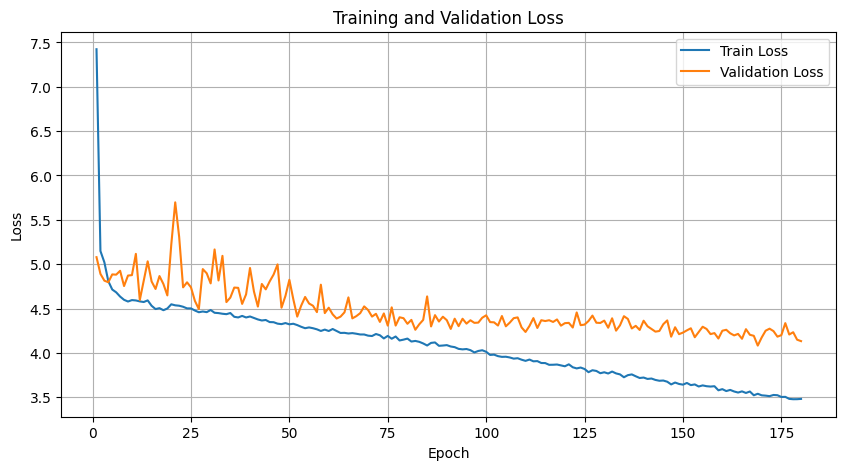

In [ ]:
input_dim = numerical_features_train.size(-1) 
hidden_dim = 64 #64
num_layers = 2
output_dim = 1
embedding_dim = 8  # Adjust as needed
num_categorical = categorical_features_train.size(-1)
num_heads = 4
max_seq_len=12  # Maximum sequence length for positional encoding
use_learnable_positional_encoding= True  # Option for learnable positional encoding
activation="relu"

# Ensure d_model is divisible by num_heads
d_model = hidden_dim + embedding_dim * num_categorical
if d_model % num_heads != 0:
    # Adjust embedding_dim to make d_model divisible by num_heads
    embedding_dim = ((d_model // num_heads) * num_heads - hidden_dim) // num_categorical
    d_model = hidden_dim + embedding_dim * num_categorical
    print(f"Adjusted embedding_dim to {embedding_dim} to ensure d_model ({d_model}) is divisible by num_heads ({num_heads}).")

ff_dim = 128 #d_model*2 #64
dropout_rate = 0.1
activity_vocab_size = 19 #int(data[activity_columns].max().max() + 1)

# Initialize model
model = RNNTransformerWithCategorical(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    activity_vocab_size=activity_vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout_rate=dropout_rate,
    num_categorical=num_categorical,
    max_seq_len=max_seq_len,
    use_learnable_positional_encoding=use_learnable_positional_encoding,
    activation=activation
)

# Early stopping parameters
early_stop_patience = 2
val_loss_threshold = 4.0  # Early stopping begins when validation loss is ≤ 4.0
loss_gap_threshold = 0.6
early_stop_counter = 0

best_val_loss = float('inf')  # Track the best validation loss
train_losses = []
test_losses = []

batch_size = 126
lr = .002
num_epochs = 180


# Learning rate scheduler: Reduce learning rate when validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Use adam optimizer with L2 penalty on weight updates
criterion = nn.MSELoss()

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    for i in range(0, numerical_features_train_split.size(0), batch_size):
        # Get batch data for training
        x_train_numerical = numerical_features_train_split[i:i + batch_size]
        x_train_categorical = categorical_features_train_split[i:i + batch_size]
        y_train = target_train_split[i:i + batch_size]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(x_train_numerical, x_train_categorical)

        # Compute loss
        loss = criterion(outputs.squeeze(), y_train)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update parameters
        optimizer.step()
        
        # Accumulate training loss
        epoch_train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = epoch_train_loss / (numerical_features_train_split.size(0) / batch_size)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, numerical_features_val.size(0), batch_size):
            # Get batch data for validation
            x_val_numerical = numerical_features_val[i:i + batch_size]
            x_val_categorical = categorical_features_val[i:i + batch_size]
            y_val = target_val[i:i + batch_size]

            # forward pass
            val_outputs = model(x_val_numerical, x_val_categorical)
            
            # loss
            val_loss += criterion(val_outputs.squeeze(), y_val).item()

        # calculate average validation loss
        avg_val_loss = val_loss / (numerical_features_val.size(0) / batch_size)
        test_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved at epoch {epoch + 1} with validation loss {best_val_loss:.4f}")
        early_stop_counter = 0  # Reset counter if validation improves
    else:
        # Check early stopping conditions
        if avg_val_loss <= val_loss_threshold and (avg_val_loss - avg_train_loss) > loss_gap_threshold:
            early_stop_counter += 1
            print(f"Early stopping condition met for {early_stop_counter} consecutive epochs.")
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break
        else:
            early_stop_counter = 0  # Reset counter if conditions are not met

    # Adjust learning rate with the scheduler
    scheduler.step(avg_val_loss)
    for param_group in optimizer.param_groups:
        print(f"Learning rate: {param_group['lr']}")

# Test phase
model.eval()
test_loss = 0
with torch.no_grad():
    for i in range(0, numerical_features_test.size(0), batch_size):
        # Get batch data for testing
        x_test_numerical = numerical_features_test[i:i + batch_size]
        x_test_categorical = categorical_features_test[i:i + batch_size]
        y_test = target_test[i:i + batch_size]

        # forward pass
        test_outputs = model(x_test_numerical, x_test_categorical)

        # compute loss
        test_loss += criterion(test_outputs.squeeze(), y_test).item()

    # calculate average test loss
    avg_test_loss = test_loss / (numerical_features_test.size(0) / batch_size)
    print(f"Test Loss: {avg_test_loss:.4f}")

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()
